In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import string
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
df = pd.read_csv('cleaned_recs.csv')
df = df[['Recommendation text']].dropna().reset_index(drop = True)
df

,Recommendation text
0,When evaluating IT products and services that ...
1,Organizations developing their own custom secu...
2,"Using CVE, CCE, and CPE names supports interop..."
3,Organizations should use authoritative CVE and...
4,Organizations should also use CPE names when i...
...,...
104,Operational oversight with appropriate respons...
105,"Intelligence oversight, including an “intellig..."
106,Conduct more detailed research and development...
107,Conduct a pilot study on tailored deterrence s...


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
stopwords = nltk.corpus.stopwords.words('english')

def plot_top_ngrams_barchart(text, n):
    stop=set(stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

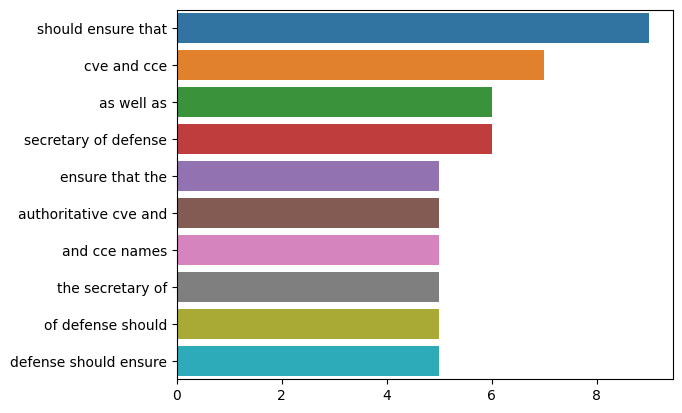

In [10]:
plot_top_ngrams_barchart(df['Recommendation text'], n=3)

In [11]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensim
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

def get_lda_objects(text):   
    stop=set(nltk.corpus.stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [12]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/shubham/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/shubham/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/shubham/nltk_data...


True

In [13]:
lda_model, bow_corpus, dic = get_lda_objects(df['Recommendation text'])

In [14]:
lda_model.show_topics()

[(0,
  '0.011*"input" + 0.011*"must" + 0.009*"strategy" + 0.007*"vendor" + 0.007*"oversight" + 0.007*"multiple" + 0.007*"specific" + 0.007*"guidance" + 0.005*"communication" + 0.005*"specification"'),
 (1,
  '0.015*"The" + 0.012*"DOD" + 0.010*"ensure" + 0.009*"Secretary" + 0.009*"Defense" + 0.008*"cyber" + 0.008*"strategy" + 0.007*"government" + 0.007*"state" + 0.006*"risk"'),
 (2,
  '0.012*"system" + 0.012*"vulnerability" + 0.010*"research" + 0.010*"sector" + 0.008*"cybersecurity" + 0.008*"agency" + 0.008*"cyber" + 0.008*"take" + 0.008*"organization" + 0.006*"Federal"'),
 (3,
  '0.022*"name" + 0.018*"CVE" + 0.014*"CCE" + 0.014*"vulnerability" + 0.013*"product" + 0.009*"ensure" + 0.009*"The" + 0.009*"CPE" + 0.009*"software" + 0.008*"used"')]

In [15]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.112587  0.058787       1        1  34.022837
2     -0.013200 -0.125094       2        1  26.173069
1      0.111943  0.041279       3        1  25.199706
0      0.013845  0.025028       4        1  14.604389, topic_info=              Term       Freq      Total Category  logprob  loglift
8             name  13.000000  13.000000  Default  30.0000  30.0000
0              CCE   9.000000   9.000000  Default  29.0000  29.0000
1              CVE  12.000000  12.000000  Default  28.0000  28.0000
11         product   8.000000   8.000000  Default  27.0000  27.0000
664            DOD   5.000000   5.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
45   communication   1.235155   5.223998   Topic4  -5.3532   0.4818
319           risk   1.216598   5.112345   Topic4  -5.3684   0.4882
271  Cybersecurity   1.219564   5.163553   Topic4  -5.3660   0.4807
64     information   1.220027   6.613544   Topic4  -5.3656   0.2336
15             use   1.219051   7.372726   Topic4  -5.3664   0.1241

[234 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
296       1  0.959134  Acquisitions
0         1  0.971639           CCE
520       2  1.002759          CIKR
662       3  0.904924           CIO
17        1  0.881170           CPE
...     ...       ...           ...
47        1  0.617643          well
47        2  0.205881          well
47        3  0.205881          well
125       4  0.577618     whitelist
706       3  0.504707          zone

[303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [18]:
# WHO NEEDS WORDCLOUDS ANYWAY

# from wordcloud import WordCloud

# def plot_wordcloud(text):
#     stop=set(nltk.corpus.stopwords.words('english'))

#     def _preprocess_text(text):
#         corpus=''
#         stem=PorterStemmer()
#         lem=WordNetLemmatizer()
#         for news in text:
#             words=[w for w in word_tokenize(news) if (w not in stop)]

#             words=[lem.lemmatize(w) for w in words if len(w)>2]

#             corpus += ' '.join(words)
#         return corpus
    
#     corpus=_preprocess_text(text)
    
#     wordcloud = WordCloud(
#         background_color='salmon', colormap='Pastel1',
#         stopwords=stop,
#         max_words=100,
#         max_font_size=30, 
#         scale=3,
#         random_state=1)
    
#     wordcloud=wordcloud.generate(corpus)

#     fig = plt.figure(1, figsize=(20, 15))
#     plt.axis('off')
 
#     plt.imshow(wordcloud)
#     plt.show()

# plot_wordcloud(df['Recommendation text'])

## Sentence embeddings

In [19]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [20]:
sentences = df['Recommendation text'].to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [21]:
sentence_embeddings.shape

(109, 768)

In [22]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

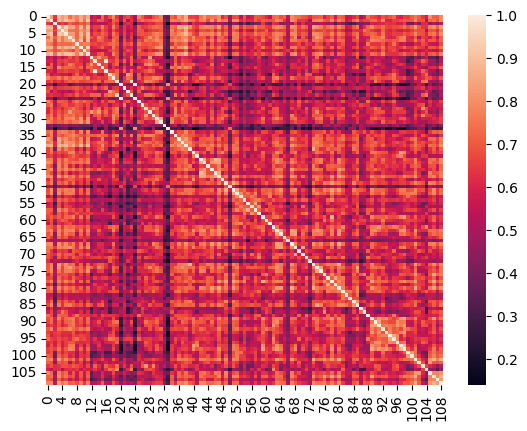

In [23]:
ax = sns.heatmap(matrix)

In [35]:
recomm = np.mean(sentence_embeddings,axis=0)

In [24]:
from tika import parser

raw = parser.from_file('12.pdf')

2023-04-04 23:39:05,599 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2023-04-04 23:39:08,710 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2023-04-04 23:39:09,090 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
text = raw['content'].replace('\n','')

In [32]:
text

'Use of the Common Vulnerabilities and Exposures (CVE) vulnerability naming schemeNIST Special Publication 800-51 Use of the Common Vulnerabilities and Exposures (CVE) Vulnerability Naming Scheme    Recommendations of the National Institute of Standards and Technology    Peter Mell Tim Grance          Use of the Common Vulnerabilities and Exposures (CVE) Vulnerability Naming Scheme  Recommendations of the National Institute of Standards and Technology NIST Special Publication 800-51      C  O  M  P  U  T  E  R     S  E  C  U  R  I  T  Y Computer Security Division Information Technology Laboratory National Institute of Standards and Technology Gaithersburg, MD 20899-8930   September 2002                              U.S. Department of Commerce Donald L. Evans, Secretary  Technology Administration Phillip J. Bond, Under Secretary for Technology  National Institute of Standards and Technology Arden L. Bement, Jr., Director  Use of the Common Vulnerabilities and Exposures (CVE) Vulnerabili

In [33]:
tokens = nltk.sent_tokenize(text)

In [36]:
relevant = []
distances = []

for sentence in tokens:
  embedd = sbert_model.encode(sentence)
  distances.append(cosine(recomm, embedd))

In [39]:
ind = np.argpartition(distances, -4)[-4:]
top4 = np.array(tokens)[ind]

In [40]:
top4

array(['Agencies should identify the CVE entries that apply to the software used in their systems and correct those vulnerabilities.',
       'Your organization’s use of CVE-compatible products can assist you by  1) determining which product covers the vulnerabilities most applicable to an agency’s network infrastructure; and   2) increasing the assurance that the alerts produced by the product(s) you choose will be able to be correlated with alerts from your other products and from your incident response center.',
       'Federal departments and agencies should give substantial consideration to the acquisition and use of security-related IT products and services that are compatible with the CVE vulnerability naming scheme.',
       'While CVE compatibility should be an important consideration in IT security product and service acquisition, federal departments and agencies should foremost consider their overall requirements (functionality, cost, performance, architecture, etc.)'],
    